In [1]:
import auto_fitting as auto
import glob
import os
auto.plt.rcParams['figure.figsize'] = [11, 8]

In [2]:
filenames = glob.glob('/Users/ryanlindley/Research/CIV/*')
CIV_targets = []
for f in filenames:
    CIV_targets.append(f.replace('/Users/ryanlindley/Research/CIV/', ''))
    
#print(CIV_targets)

In [558]:
name = CIV_targets[122]
print(name)

PG-1522+101


In [559]:
directory = '/Users/ryanlindley/Research/CIV/' + name
os.chdir(directory)
os.getcwd()

'/Users/ryanlindley/Research/CIV/PG-1522+101'

In [560]:
wl1, f1, gamma1, elem, state = (1548.187, 0.19, 0.00324, 'C', 'IV')
wl2, f2, gamma2, elem, state = (1550.772, 0.0952, 0.00325, 'C', 'IV')

path = '/Users/ryanlindley/Research/CIV/' + name + '/CIV.bin3.linespec'
wl, fl, fe, ctn = auto.np.loadtxt(path).transpose()
lsf = auto.np.loadtxt('/Users/ryanlindley/Research/CIV.old_setup/CIV.lsf')

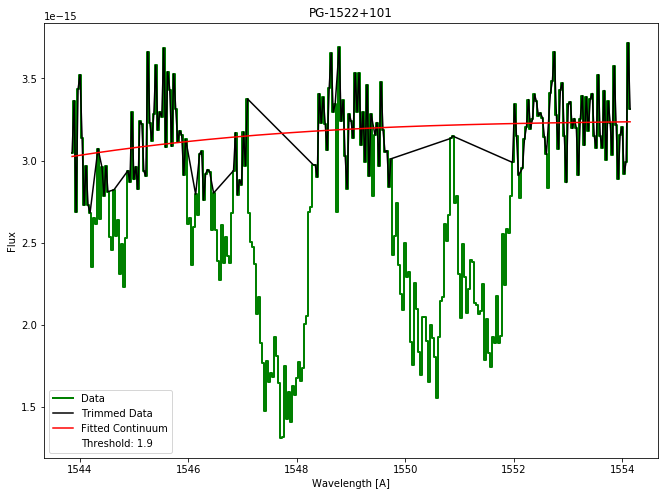

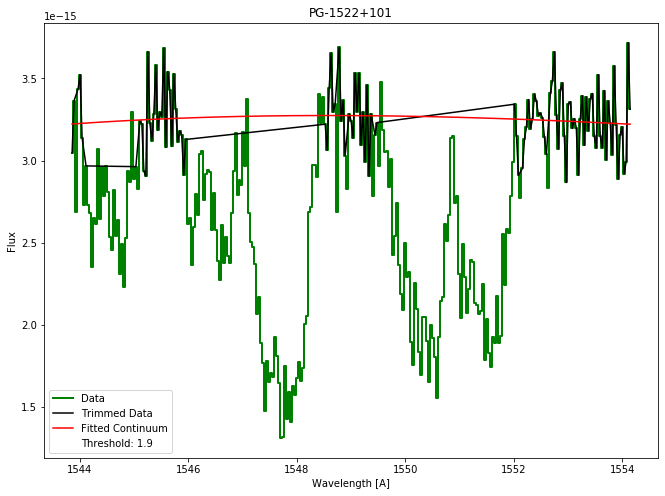

In [563]:
new_ctn = auto.find_continuum(name, wl, fl, fe, ctn, [True]*len(wl))

ctn_flag = auto.mask_wl(wl, [1544.2, 1545, 1546, 1548.5, 1549.5, 1552])  # add custom ctn if needed 
manual_ctn = auto.find_continuum(name, wl, fl, fe, ctn, ctn_flag)


In [564]:
new_ctn = manual_ctn # only include when manual continuum us found

fn = fl / new_ctn
fne = fe / new_ctn

In [565]:
#chi, chi_mean = auto.find_chi(wl, fl, fe, new_ctn)
#auto.plot_chi_histogram(chi, chi_mean)

#flag_chi = auto.mask_wl(wl, [1546, 1546.7, 1548, 1551.2]) # mask out regions for better calculation of chi histogram

#new_chi, new_chi_mean = auto.find_chi(wl[flag_chi], fl[flag_chi], fe[flag_chi], new_ctn[flag_chi])
#auto.plot_chi_histogram(new_chi, new_chi_mean)

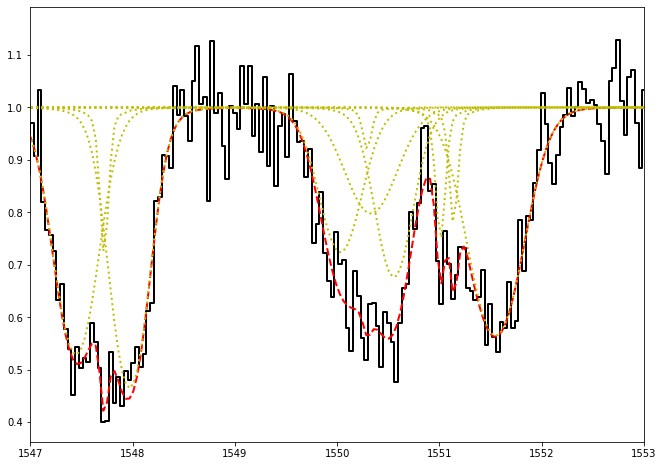

[  13.91231371   49.83202638 -144.78760431   13.73806413   -0.93366042
  -92.45024575   13.94499282   43.27052032  -43.544369     13.54742561
    3.12389574   44.39792975   13.19964944    0.70408649   68.38493251
   13.84476527   63.09842028  -86.98348739   14.25700036   64.17178204
  148.81041166]


In [573]:
x0 = [13.5, 20.3, auto.Wave2V(1547.5, wl1)] + [13.5, 20.3, auto.Wave2V(1547.8, wl1)] + [13, 20.3, auto.Wave2V(1548.1, wl1)] + [13, 20.3, auto.Wave2V(1551, wl2)] + [13, 20.3, auto.Wave2V(1551.7, wl2)] + [13, 20.3, auto.Wave2V(1550.5, wl2)] + [13, 20.3, auto.Wave2V(1552, wl2)] #+ [13, 20.3, auto.Wave2V(1551.1, wl1)] #+ [13, 20.3, auto.Wave2V(1550.5, wl2)] #+ [13, 20.3, auto.Wave2V(1551.3, wl2)] #+ [13.5, 20.3, auto.Wave2V(1552.7, wl2)] #+ [13, 20.3, auto.Wave2V(1551.67, wl2)] 
feat = [0, 0 ,0, 2, 2, 2, 2, 2] #which features used to model 0 - both, 1 - strong, 2 - weak
p0, cov, a, b, c = auto.leastsq(auto.fitting, x0, full_output=1, args=(feat, wl, wl1, wl2, f1, f2, gamma1, gamma2, lsf, fn, fne, [1547, 1553]))


#p1 = [ 14.53965, 24.06391002, -71.09040917,  13.52129405, 137.31813447, -27.9473738,   13.90456244,  15.60159991, -24.45908188]
auto.plot_model(p0, feat, wl, fn, wl1, wl2, f1, f2, gamma1, gamma2, lsf, [1547, 1553]) #normally [1547, 1553]
print(p0)

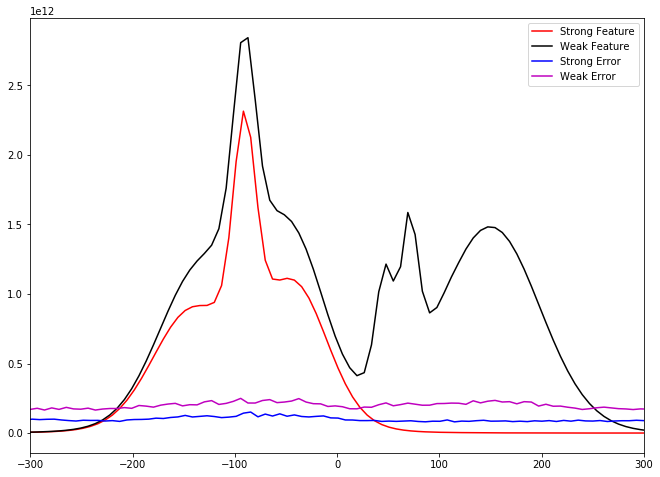

[  13.91231371   49.83202638 -144.78760431   13.73806413   10.
  -92.45024575   13.94499282   43.27052032  -43.544369     13.54742561
    3.12389574   44.39792975   13.19964944    0.70408649   68.38493251
   13.84476527   63.09842028  -86.98348739   14.25700036   64.17178204
  148.81041166]


In [575]:
p0[4] = 10
N1, N2 = auto.make_features(p0, feat, wl, wl1, wl2, lsf, gamma1, gamma2)
Ne1 = auto.nfle2Nev(fn, fne, f1, wl1)
Ne2 = auto.nfle2Nev(fn, fne, f2, wl2)
auto.plot_features(wl, wl1, wl2, N1, N2, Ne1, Ne2, [-300, 300])
print(p0)

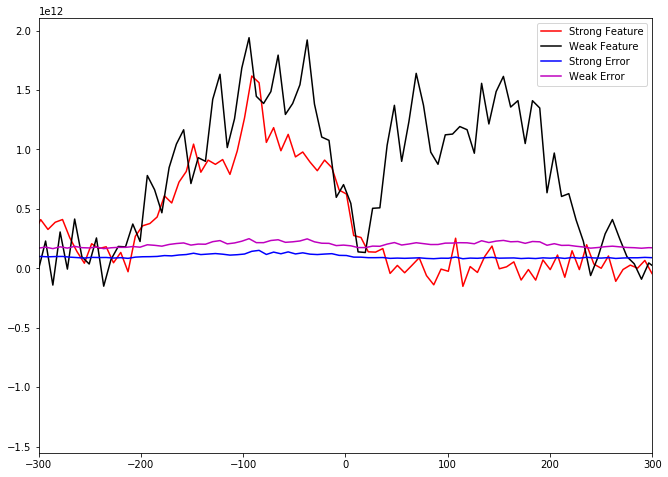

In [576]:
N1r, N2r = auto.add_residual(p0, N1, N2, feat, wl, wl1, wl2, f1, f2, gamma1, gamma2, lsf, fn)
auto.plot_features(wl, wl1, wl2, N1r, N2r, Ne1, Ne2, [-300, 300])

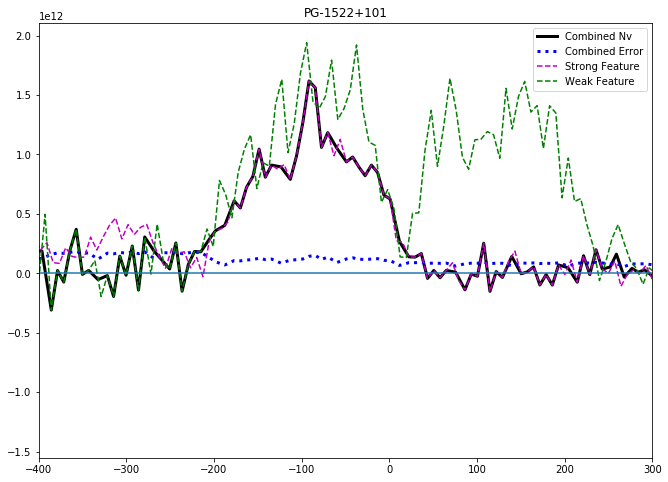

In [582]:
strong_flag = auto.mask_v(wl, wl1, [-400, -200]) # add masking for any regions not to be used in combined data
weak_flag = auto.mask_v(wl, wl2, [-200, 250])
v1, v2, Nv1, Nv2, Nve1, Nve2 = auto.remove_regions(strong_flag, weak_flag, wl, wl1, wl2, N1r, N2r, Ne1, Ne2)

v_bins, Nv_bins, Nve_bins = auto.make_bins(v1, v2, Nv1, Nv2, Nve1, Nve2)

v_final, Nv_final, Nve_final =  auto.final_data(v_bins, Nv_bins, Nve_bins)

auto.plot_final_data(wl, wl1, wl2, N1r, N2r, v_final, Nv_final, Nve_final, name, [-400, 300])

In [28]:
#N = auto.find_N(-115, 110, v_final, Nv_final)
#print('Column Density: ', N)

In [583]:
data = auto.np.c_[v_final, Nv_final, Nve_final]
regions = [[-400, -250], [-225, 25], [0, 250]]

auto.np.savetxt('CIV.data', data)
auto.np.savetxt('CIV.regions', regions, fmt='%1.3i')
auto.save_final_data_plot(wl, wl1, wl2, N1r, N2r, v_final, Nv_final, Nve_final, name, [-400, 300])
auto.save_final_continuum_data(wl, fl, new_ctn, name)